In [ ]:
# dataset = cifar10 
# model = mobilenet 
# optimizer = ADAM (0.0001)
# loss = categorical_crossentropy 
# batch_size = 32 
# decay = l2 (0.01)
# augmentation = off

In [ ]:
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [2]:
batch_size=32 
epochs=100
num_classes=10 
depth=20 

In [3]:
model_type = 'MobileNet%d' % (depth)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
x_train = x_train/255 
x_test = x_test/255 

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
input_shape=x_train.shape[1:]

170500096/170498071 [==============================] - 12s 0us/step


In [5]:
#datagen = ImageDataGenerator(rotation_range=40, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train, y_train)

In [6]:
def mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=l2(l=l2_decay),
        input_shape=input_size + (3,)))
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=l2(l=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.01, N_CLASSES=10)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        2

In [7]:
#model_tf = tf.keras.applications.mobilenet.MobileNet(input_shape=(32, 32, 3), weights=None, classes=10)
#print(model_tf.summary())

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [9]:
batch_size = 32 
steps = int(x_train.shape[0]/batch_size) 

history = model.fit(x_train, y_train, steps_per_epoch=steps, epochs=epochs, verbose=2, validation_data=(x_test, y_test))

Epoch 1/100
1562/1562 - 29s - loss: 43.1267 - accuracy: 0.1625 - val_loss: 34.6035 - val_accuracy: 0.2155
Epoch 2/100
1562/1562 - 18s - loss: 28.4076 - accuracy: 0.2525 - val_loss: 22.7849 - val_accuracy: 0.3005
Epoch 3/100
1562/1562 - 18s - loss: 18.2931 - accuracy: 0.3257 - val_loss: 14.3423 - val_accuracy: 0.3573
Epoch 4/100
1562/1562 - 19s - loss: 11.5088 - accuracy: 0.3789 - val_loss: 9.1567 - val_accuracy: 0.4076
Epoch 5/100
1562/1562 - 18s - loss: 7.6034 - accuracy: 0.4280 - val_loss: 6.3575 - val_accuracy: 0.4479
Epoch 6/100
1562/1562 - 18s - loss: 5.5434 - accuracy: 0.4690 - val_loss: 4.9211 - val_accuracy: 0.4544
Epoch 7/100
1562/1562 - 18s - loss: 4.3899 - accuracy: 0.5023 - val_loss: 4.1541 - val_accuracy: 0.4568
Epoch 8/100
1562/1562 - 19s - loss: 3.6975 - accuracy: 0.5320 - val_loss: 3.5869 - val_accuracy: 0.4898
Epoch 9/100
1562/1562 - 18s - loss: 3.2251 - accuracy: 0.5647 - val_loss: 3.2363 - val_accuracy: 0.5036
Epoch 10/100
1562/1562 - 18s - loss: 2.8818 - accuracy: 0

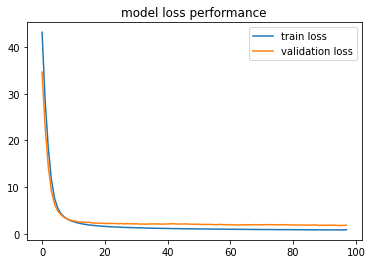

In [10]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

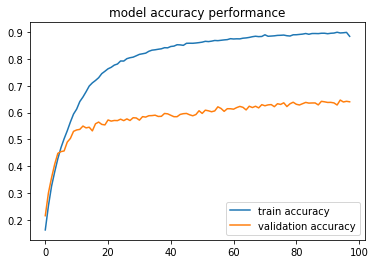

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.8847 - accuracy: 0.6400


[1.8846632242202759, 0.6399999856948853]